# Lesson 4 - Introduction to random forests

> How to train a Random Forest model to predict housing prices and evaluate the quality of the model's predictions.

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/lewtun/dslectures/master?urlpath=lab/tree/notebooks%2Flesson04_intro-to-random-forests.ipynb) 
[![slides](https://img.shields.io/static/v1?label=slides&message=lesson04_intro-to-random-forests.pdf&color=blue&logo=Google-drive)](https://drive.google.com/open?id=18yESZldXJrdXiaOQWmiA35-8vIqOnNK8)

## Learning objectives

* Understand the main steps involved in training a machine learning model
* Gain an introduction to scikit-learn's API
* Understand the need to generate a training and validation set

## References

This lesson is adapted from Jeremy Howard's fantastic online course [_Introduction to Machine Learning for Coders_](https://course18.fast.ai/ml), in particular:

* [1 - Introduction to Random Forests](https://course18.fast.ai/lessonsml1/lesson1.html)

You may also find the following textbook chapters and blog posts useful:

* Chapters 2 & 5 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron
* [About Train, Validation and Test Sets in Machine Learning](https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7)

## Homework

* Solve the exercises included in this notebook
* Read chapters 6 and 7 of _Hands-On Machine Learning with Scikit-Learn and TensorFlow_ by Aurèlien Geron

## The data

In this lesson we will analyse the preprocessed table of clean housing data and their addresses that we prepared in lesson 3:

* `housing_processed.csv`

## What is a machine learning model?

<div style="text-align: center">
<img src='images/machine_learning.png' width='300'>
</div>

[Tom Mitchell](https://en.wikipedia.org/wiki/Tom_M._Mitchell), one of the pioneers of machine learning, proposed this definition:

> A computer program is said to learn from experience $E$ with respect to some class of tasks $T$ and performance measure $P$ if its performance at tasks in $T$, as measured by $P$, improves with experience $E$.

Framed in our example to predict housing prices in California (task $T$), we can run a Random Forest algorithm on data about past housing prices (experience $E$) and, if it has successfully "learned", it will then do better at predicting future housing prices (performance measure $P$).

## Import libraries

In [ ]:
# reload modules before executing user code
%load_ext autoreload
# reload all modules every time before executing Python code
%autoreload 2
# render plots in notebook
%matplotlib inline

In [ ]:
# data wrangling
import pandas as pd
import numpy as np
from dslectures.core import *
from pathlib import Path

# data viz
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(color_codes=True)
sns.set_palette(sns.color_palette("muted"))

# ml magic
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

## Load the data

As usual, we can download our datasets using our helper function `get_datasets`:

In [ ]:
get_dataset('housing_processed.csv')

Download of housing_processed.csv dataset complete.


We also make use of the `pathlib` library to handle our filepaths:

In [ ]:
DATA = Path('../data/')
!ls {DATA}

housing.csv                  housing_processed.csv
housing_addresses.csv        imdb.csv
housing_gmaps_data_raw.csv   uc
housing_merged.csv           word2vec-google-news-300.pkl


In [ ]:
housing_data = pd.read_csv(DATA/'housing_processed.csv'); housing_data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,city,postal_code,rooms_per_household,bedrooms_per_household,bedrooms_per_room,population_per_household,ocean_proximity_INLAND,ocean_proximity_<1H OCEAN,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN,ocean_proximity_ISLAND
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,69,94705,6.984127,1.023810,0.146591,2.555556,0,0,1,0,0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,620,94611,6.238137,0.971880,0.155797,2.109842,0,0,1,0,0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,620,94618,8.288136,1.073446,0.129516,2.802260,0,0,1,0,0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,620,94618,5.817352,1.073059,0.184458,2.547945,0,0,1,0,0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,620,94618,6.281853,1.081081,0.172096,2.181467,0,0,1,0,0


> Tip: We often use `DataFrame.head()` to peek at the first 5 rows of a `pandas.DataFrame`. When you have a lot of columns, you may find it is simpler to peek at the _transpose_ with `DataFrame.head().T`

In [ ]:
housing_data.head().T

,0,1,2,3,4
longitude,-122.230000,-122.220000,-122.240000,-122.250000,-122.250000
latitude,37.880000,37.860000,37.850000,37.850000,37.850000
housing_median_age,41.000000,21.000000,52.000000,52.000000,52.000000
total_rooms,880.000000,7099.000000,1467.000000,1274.000000,1627.000000
total_bedrooms,129.000000,1106.000000,190.000000,235.000000,280.000000
population,322.000000,2401.000000,496.000000,558.000000,565.000000
households,126.000000,1138.000000,177.000000,219.000000,259.000000
median_income,8.325200,8.301400,7.257400,5.643100,3.846200
median_house_value,452600.000000,358500.000000,352100.000000,341300.000000,342200.000000
city,69.000000,620.000000,620.000000,620.000000,620.000000


---

#### Exercise #1

Even though you may be told a dataset has been cleaned and prepared for training a model, you should always perform some sanity checks! 

* Check that `housing_data` is free of missing values
* Check that all columns are numerical

---

## Select a performance measure

Before we can train any model, we need to think about which performance measure we wish to optimise for. For regression problems the Root Mean Square Error (RMSE) is often used as it measures the _**standard deviation**_ of the errors the algorithm makes in its predictions and gives a higher weight to large errors. For example, an RMSE equal to 50,000 means that about 68% of the algorithm's predictions fall within 50,000 CHF of the actual value, and about 95% fall within 100,000 CHF.

> Note: In general, lower values of RMSE indicate a better fit to the data.

Mathematically, the formula for RMSE is:

$$ \mathrm{RMSE} = \sqrt{\frac{1}{m}\sum_{i=1}^m \left(\hat{y}_i - y_i\right)^2}$$

where $m$ is the number of instances in the dataset you are measuring the RMSE on, $\hat{y}_i$ is the model's prediction for the $i^{th}$ instance, and $y_i$ is the actual label. Let's create a simple function that uses scitkit-learn's [mean_squared_error function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) (which is just RMSE$^2$):

In [ ]:
def rmse(y, yhat):
    """A utility function to calculate the Root Mean Square Error (RMSE).
    
    Args:
        y (array): Actual values for target.
        yhat (array): Predicted values for target.
        
    Returns:
        rmse (double): The RMSE.
    """
    return np.sqrt(mean_squared_error(y, yhat))

---
#### Exercise #2

Whenever you create a Python function it is a good idea to test that it behaves as you expect on some dummy data. Given the two NumPy arrays:

```python
y_dummy = np.array([2,2,3])
yhat_dummy = np.array([0,2,6])
```

check that our `rmse` function matches what you would get by calculating the explicit formula for RMSE. You may find the `numpy.sum()` and `array.size` methods to be useful.

---

> Note: Another common metric for evaluating regression models is the coefficient of determination $R^2 = 1 - u/v$, where $u = \sum_i (y_{i} - \hat{y}_{i})^2$ is the residual sum of squares and $v=\sum_i(y_{i} - \bar{y}_{i})^2$ is the total sum of squares. Better models have $R^2$ values closer to 1.

## Introducing scikit-learn

Now that we've checked that the training data is clean and free from obvious anomalies, it's time to train our model! To do so, we will make use of the scikit-learn library.

scikit-learn is one of the best known Python libraries for machine learning and provides efficient implementations of a large number of common algorithms. It has a uniform _Estimator API_ as well as excellent online documentation. The main benefit of its API is that once you understand the basic use and syntax of scikit-learn for one type of model, switching to a new model or algorithm is very easy.

**Basics of the API**

The most common steps one takes when building a model in scikit-learn are:
1. Choose a class of model by importing the appropriate estimator class from scikit-learn.
2. Choose model _hyperparameters_ by instantiating this class with the desired values.
3. Arrange data into a feature matrix and target vector (see discussion below).
4. Fit the model to your data by calling the `fit()` method.
5. Evaluate the predictions of the model:
    * For supervised learning we typically predict _labels_ for new data using the `predict()` method.
    * For unsupervised learning, we often transform or infer properties of the data using the `transform()` or `predict()` methods.
    
Let's go through each of these steps to build a Random Forest regressor to predict California housing prices.

### Choose a model

In scikit-learn, every class of model is represented by a Python class. We want a Random Forest regressor, so looking at the online [docs](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) we should import the `RandomForestRegressor`:

In [ ]:
from sklearn.ensemble import RandomForestRegressor

### Choose hyperparameters

Once we have chosen our model class, there are still some options open to us:

* What is the maximum depth of the tree? The default is `None` which means the nodes are expanded until all leaves are pure.
* Other parameters can be found in the [docs](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), but for now we take a simple model with just 10 trees.

The above choices are often referred to as _hyperparameters_ or parameters that must be set before the model is fit to the data. We can instantiate the `RandomForestRegressor` class and specify the desired hyperparameters as follows:

In [ ]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)

> Note: You will often see the function argument `random_state` in scikit-learn and other libraries in the PyData stack. This parameter usually controls the random seed used to generate the function's output and setting is explicitly allows us to have reproducible results.

### Arrange data into a feature matrix and target vector

scikit-learn requires that the data be arranged into a two-dimensional feature matrix and a one-dimensional target array. By convention: 

* The feature matrix is often stored in a variable called `X`. This matrix is typically two-dimensional with shape `[n_samples, n_features]`, where `n_samples` refers to the number of row (i.e. housing districts in our example) and `n_features` refers to all columns except `median_house_value` which is our target.
* The target or label array is usually denoted by `y`.

---

#### Exercise #3

Create the feature matrix `X` and target vector `y` from `housing_data`.

---

### Fit the model to your data

Now it is time to apply our model to data! This can be done with the `fit()` method:

In [ ]:
model.fit(X, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

### Evaluate the predictions

The final step is to generate predictions and evaluate them with our chosen performance metric, in this case the RMSE.

In [ ]:
yhat = model.predict(X)

In [ ]:
rmse(y, yhat)

19186.0842161522

This is not a bad score since the majority of the house prices fall in the range of $115,000-250,000

In [ ]:
housing_data['median_house_value'].describe()

count     19443.000000
mean     191793.406162
std       96775.724042
min       14999.000000
25%      116700.000000
50%      173400.000000
75%      247100.000000
max      499100.000000
Name: median_house_value, dtype: float64

and thus we are looking at roughly a 10-20% error in our predictions.

> Warning: Evaluating our model's predictions on the same data it was trained on is usually a recipe for disaster! Why? The problem is that the model may memorise the structure of the data it sees and fail to provide good predictions when shown new data.

## Better evaluation using training and validation splits

One way to measure how well a model will generalise to new cases is to split your data into two sets: the _**training set**_ and the _**validation set**_. As these names imply, you train your model using the training set and validate it using the validation set. The error rate on new cases is called the _**generalisation error**_ and by evaluating your model on the validation set, you get an estimation of this error.

Creating a validation set is theoretically quite simple: just pick some instances randomly and set them aside (we set the random number generator's seed `random_state` so that is always generates the same shuffled indices):

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

print(f'{len(X_train)} train rows + {len(X_valid)} valid rows')

15554 train rows + 3889 valid rows


With these two datasets, we first fit on the training set and evaluate the prediction on the validation one:

In [ ]:
model = RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=-1, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [ ]:
y_pred = model.predict(X_valid)
rmse(y_valid, y_pred)

46106.026083048855

## Visualising the model errors

Although numerical scores are useful, deeper insights can often be gained by _visualising_ the errors the model makes. Let's look at two common ways to diagnose _regression_ models.

### Prediction errors

To get a sense of how often our model is predicting values that are close to the expected values, we'll plot the actual `median_house_value` labels from the test dataset against the predicted value generated by our final model:

In [ ]:
def plot_prediction_error(fitted_model, X, y):
    """
    A utility function to visualise the prediction errors of regression models.
    
    Args:
        fitted_model: A scikit-learn regression model.
        X: The feature matrix to generate predictions on.
        y: The target vector compare the predictions against.
    """
    y_pred = model.predict(X)
    plt.figure(figsize=(8, 4))
    sns.scatterplot(y, y_pred)
    sns.lineplot([y.min(), y.max()], [y.min(), y.max()], lw=2, color="r")
    plt.xlabel("Actual Median House Price")
    plt.ylabel("Predicted Median House Price")
    plt.title(f"Prediction Error for {model.__class__.__name__}")
    plt.show()

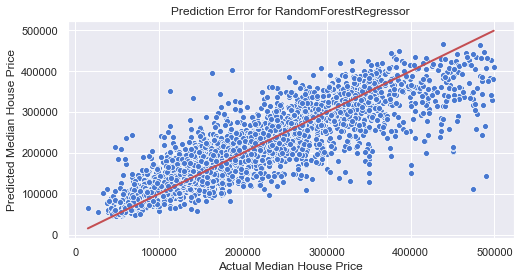

In [ ]:
plot_prediction_error(model, X_valid, y_valid)

What we’re looking for here is a clear, linear relationship between the predicted and actual values. The red line denotes what could be considered an "optimal" model, so we want our points to be bunched around this line. We can see the apart from a few outliers, the random forest performs fairly well. (In fact those outliers might suggest something is fishy with the data or that these houses are special for reasons not reflected in the data.)

### Residual plots

A residual is the difference between the labeled value and the predicted value for each instance in our dataset: 

$$ \mathrm{residual} = y_\mathrm{actual} - y_\mathrm{predicted} $$

We can plot residuals to visualize the extent to which our model has captured the behavior of the data. By plotting the residuals for a series of instances, we can check whether they’re consistent with random error; we should not be able to predict the error for any given instance. If the data points appear to be evenly (randomly) dispersed around the plotted line, our model is performing well. In some sense, the resulting plot is a rotated version of our prediction error one above:

In [ ]:
def plot_residuals(fitted_model, X, y):
    '''
    A utility function to visualise the residuals of regression models.
    
    Args:
        fitted_model: A scikit-learn regression model.
        X: The feature matrix to generate predictions on.
        y: The target vector compare the predictions against.   
    '''
    y_pred = model.predict(X)

    sns.residplot(y_pred, y - y_pred)
    plt.ylabel('Residuals')
    plt.xlabel('Predicted Median House Price')
    plt.title(f'Residuals for {model.__class__.__name__}')
    plt.show()

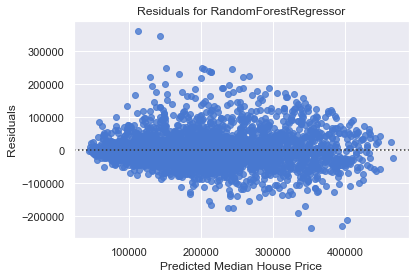

In [ ]:
plot_residuals(model, X_valid, y_valid)

What we’re looking for is a mostly symmetrical distribution with points that tend to cluster towards the middle of the plot, ideally around smaller numbers of the y-axis. If we observe some kind of structure that does not coincide with the plotted line, we have failed to capture the behavior of the data and should either consider some feature engineering, selecting a new model, or an exploration of the hyperparameters.

In the case above, we see that again the outliers suggest some room for improvement with our Random Forest model.

---

#### Exercise #3

Use the `plt.subplots()` functionality from lesson 3 to create a new function `plot_errors_and_residuals` that combines the above plots into a single figure. You may find the `ax.set_xlabel()`, `ax.set_ylabel()`, and `ax.set_title()` functions are useful for configuring the labels and title on each individual plot.


#### Exercise #4

Instead of using an ensemble of decision trees, scikit-learn also provides an estimator to train a _single_ decision tree on the data (see documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn.tree.DecisionTreeRegressor)). Repeat the same 5 steps above for a decision tree regressor, using the default hyperparameters. Do you notice anything unusual in the performance metrics if you fit the model on the whole dataset?

---